**Описание проекта**

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные компании.

**Шаг 1. Общая информация**

Импорт библиотек

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [6]:
df = pd.read_csv('(датасет) games.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В таблице более 16 тыс строк в 10 колонках. 


1.  Названия колонок не в нижнем регистре. При обработке данных я исправлю это переименованием.
2.  Есть пропуски и больше всего их в столбцах оценки пользователей и экспертов, а также возрастной рейтинг, и я заметила, что обычно наличие этих пропусков по строке сопадает, т.е. если пропуск в оценке пользователей, то проуски и в оценке критиков, и в рейтинге. У меня предположение, что либо игра, либо платформа, на которой она выпущена, не собирает эти данные. Возможно, по какой-то другой причине не заполняются эти данные. Что касается заполнения этих пропусков, то вероятно, можно посмотреть подробнее: если есть данные по рейтингу в одной стране, но нет в другой, то можно было бы заполнить их. Однако я воздержусь, в разных странах могут быть отличающиеся законы относительно возрастной категории игр. Аналигочно с оценкой пользователей и критиков - заполнить средним или медианой, это если вообще такие данные есть, из которых это можно рассчитать. Оценка пользователей по странам могут отличаться: то, что нравится в Японии, может совсем не нравится в Европе. На данном этапе я не нахожу достаточных оснований, чтобы заполнить пропуски каким бы то ни было значением.
3.  Предстоит делать расчеты по годам, поэтому приведу тип данных в колонке год выпуска к удобному. В столбцах о продажах данные типа float. Лучше перевести в целочесиленный, однако там измерения в млн и десятые и сотые доли нельзя терять. Либо добавлять нули и переводить в int, либо оставлять float. Пока не ясно, повредит ли это исследованию. С вещественными можно проводить математические операции. В столбцах оценка экспертов и рейтинг строчные данные. Для рейтинга это нормально - он обозначается буквами (Е, М и тп), а вот оценка пользователя (на предварительном просмотре) в числах,  как и оценка экспертов. И для расчетов нужен тип данных int иил float

 

**Шаг 2. Предобработка данных**

В этом шаге предстоит выполнить:


*   Переименование
*   Обработка дубликатов
*   Обработка пропусков
*   Изменение типа данных 



Меняю регистр в названиях колонок

In [8]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Проверяю на дубликаты

In [9]:
df.duplicated().sum()

0

Дубликатов нет

In [10]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Подробнее рассмотрим пропуски

In [6]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Две игры 1993 года, никаких данных в оценках, рейтинге и жанре, продажи в 3 случаях из 6 нулевые. Полагаю, эти строки никак не повлияют на исследование (2 и более чем 16 тыс), поэтому я их удалю методом dropna()

In [11]:
df = df.dropna(subset=['name'])
df['name'].isna().sum()

0

В колонке год выпуска 269 пропусков. Посмотрю подробнее, сделав срез

In [12]:
df[df['year_of_release'].isna()]




,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Заполню пропуски по названию игры. Игры, которые выходили на разных платформах, иногда имеют сведения о годе выпуска, иногда - нет.

In [13]:
df_t1 = df.groupby('name')['year_of_release'].transform('min')
df['year_of_release'] = df['year_of_release'].fillna(df_t1)
df['year_of_release'].isna().sum()

146

Удалось таким образом заполнить 123 пропуска (269-146)

Пропуски в пользовательском и экспертном рейтинге заполню не характерным значением, в дальнейшем буду делать срез, чтобы не включать их в исследование.

In [14]:
df['critic_score'] = df['critic_score'].fillna(-1)
df['critic_score'].value_counts()


-1.0     8576
 70.0     256
 71.0     254
 75.0     245
 78.0     240
         ... 
 20.0       3
 21.0       1
 17.0       1
 22.0       1
 13.0       1
Name: critic_score, Length: 83, dtype: int64

In [15]:
df['rating'] = df['rating'].fillna('no rating')
df['rating'].value_counts()

no rating    6764
E            3990
T            2961
M            1563
E10+         1420
EC              8
K-A             3
RP              3
AO              1
Name: rating, dtype: int64

Пропуски в возрастном рейтинге: здесь строковые значения, к тому же рейтинг присваивает специальная организация, по каким криетриям - мне неизвестно, заполнить на свое усмотрение будет ошибкой. Однако можно заполнить пропуски значением "no rating", чтобы также можно было учитывать эту позицию при исследовании

In [16]:
df['user_score'] = df['user_score'].replace('tbd', '')
df['user_score'] = pd.to_numeric(df['user_score'])
df['user_score'].isna().sum()


9123

 В столбце оценка пользователя 2424 строки с значением tbd. Вероятно, это to be determined (пока не определено). 14% данных с таким значением. И из-за него данные имеют тип object. Хотелось бы перевести его в float, чтобы можно было выполнять математические операции. Больше всего это значение (tbd) походит на Nan, на его я и заменю. А потом заполню пропуски по аналогии с экпертным рейтингом.
 

In [17]:
df['user_score'] = df['user_score'].fillna(-1)
df['user_score'].isna().sum()


0

Подсчет суммарных продаж по всем регионам сохраню в отдельном столбце

In [20]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,no rating,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,no rating,31.38


*Вывод по шагу Предобработка*

В предобработке были проведены шаги согласно плану
- Заменены названия столбцов
- Обработаны пропуски 
- Посчитаны суммарные продажи

Пропуски были обработаны в колонках год выпуска (по году выпуска на других платформах), в пользовательском рейтинге помимо числовых значений было строковое значение tbd, предположительно to be determined. Для проведения математических операций нужно, чтобы тип данных был хотя бы float, поэтому значение было заменено на пропуски. Пропусков в экспертном и пользовательском рейтинге довольно много, около половины данных. Заполнять их каким-либо числовым значением нет достаточных оснований. Для возможности дальнейших расчетов они были заменены нехарактерным одинаковым значением (-1), чтобы в дальнейшем множно было эту часть "срезать" и не включать в исследование.

**Шаг 3. Исследовательский анализ**

Посмотрю на гистограмму значений по году выпуска

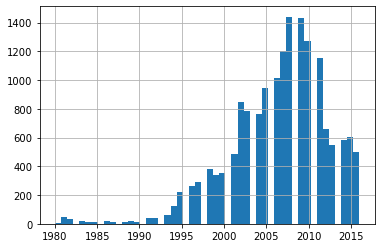

In [21]:
df['year_of_release'].hist(bins=50)
plt.show()

Больше всего игр выпускалось в 2008-2009 гг., основная часть значений распределена в периоде с 2000 по 2015 гг. Период до 1995 года, полагаю, не важен для исследования. Там не много значений, это выбросы. Считаю, что для исследования следует брать период 1995-2015

Находим платформы с наибольшими суммарными продажами

In [22]:
top = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).to_frame()
top.head(10)

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


Далее нахожу суммарные продажи по годам и по платформам. Сначала делаю срез по таблице с топовыми платформами, далее сводной таблицей подсчитываю суммарные продажи по годам.

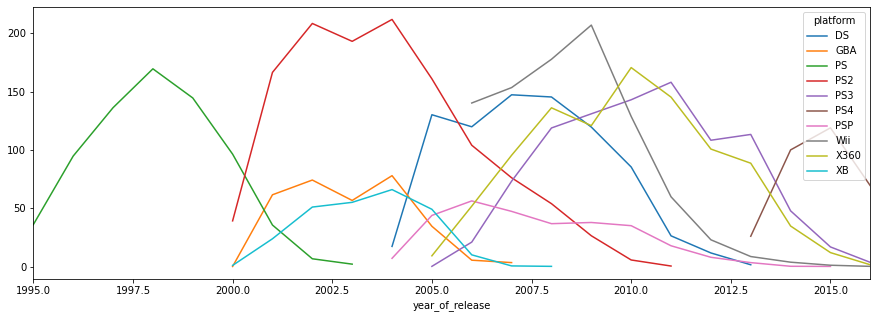

In [23]:
top_sales = df[df['platform'].isin(['PS2','X360','Wii','PS3','DS','PS','GBA','PS4','PSP','XB'])]
top_sales_pivot = top_sales.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
top_sales_pivot.plot(figsize=(15,5))
plt.xlim(1995,2016)
plt.show()


График показывает распределение суммарных продаж по платфрмам по годам. По нему можно сделать вывод, что характерный срок, когда появляются новые и исчезают старые платформы - 8-10 лет.

Исходя из вышесказанного, для исследования я выберу период не более 5 последних лет. Как показали результаты исследований по годам, высокие продажи 10-летней давности могут не иметь никакого значения, так как, например, сама платформа устарела/исчезла и более не делает продаж, несмотря на то, что она лидировала по продажам.

Сохраняю срез по актуальным данным

In [24]:
df_actual = df.query('year_of_release > 2010')
df_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
29,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,no rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013.0,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,no rating,14.60


Нахожу лидеров по продажам

In [25]:
top_actual = df_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).to_frame()
top_actual

,total_sales
platform,
PS3,447.69
X360,382.75
PS4,314.14
3DS,258.21
XOne,159.32
PC,98.67
Wii,96.39
WiiU,82.19
PSV,53.81


В лидерах по продажам в актуальной таблице PS3, X360 и PS4. Выводы отличаются от выводов по общей таблице за все года, там первое место было у PS2, а PS3 только 4-ая. Зато в актуальных данных PS2 на 10м месте. Устаревание платформы налицо.

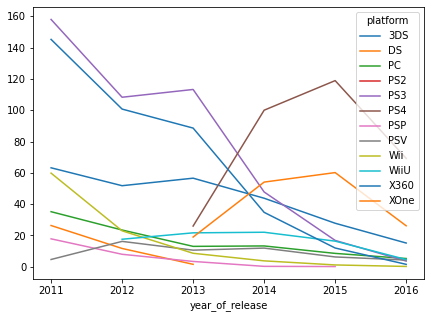

In [26]:
df_actual_pivot = df_actual.pivot_table(index='year_of_release',columns='platform', values='total_sales', aggfunc='sum')
df_actual_pivot.plot(figsize=(7,5))
plt.show()

Оба лидера PS3 и X360 самые высокие продажи показывали в 2011 и с тех пор продажи падали. Вероятно, можно сказать, что эти платформы находятся в завершающей стадии цикла и скоро исчезнут, их заменят более новые. Потенциально прибыльной назвала бы XOne - у нее с 2013 рост, если учитывать что данный по продажам за 2016 еще неполные. В 2017-2018 она может выйти на пик продаж. Также потенциально прибыльной можно считать WiiU, которая с 2012 показывает рост продаж, однако более плавный, нежели у XOne.

График "ящик с усами" по продажам с топовых платформ также показывает лидерство указанных ранее платформ. У предположительно набирающих обороты Xone и WiiU очевидно разный объем продаж, а по медианному значению они равны.

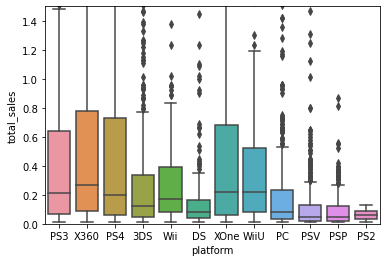

In [27]:
sns.boxplot(x=df_actual['platform'], y=df_actual['total_sales'])
plt.ylim(0,1.5)
plt.show()

Рассмотрим одну из популярных платформ

0.02495036920171559

0.37613768367126116

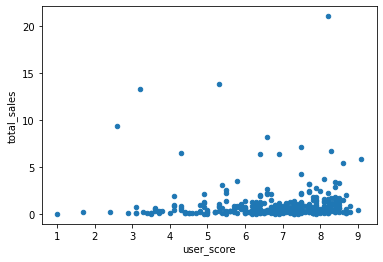

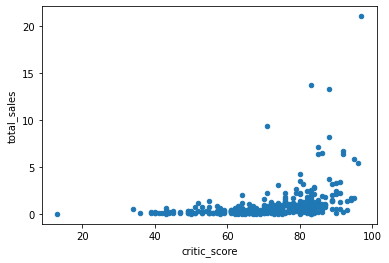

In [30]:
ps3 = df_actual.query('platform == "PS3" and user_score>0 and critic_score>0')
ps3.plot(x='user_score', y='total_sales', kind='scatter')
ps3.plot(x='critic_score', y='total_sales', kind='scatter')
display(ps3['user_score'].corr(ps3['total_sales']))
ps3['critic_score'].corr(ps3['total_sales'])

Показатель корреляции между продажами и отзывами пользователей - 0.02. Можно сказать нулевая. Это также и отображается на диаграмме рассеяния. А вот корреляция с отзывами эспертов уже - 0.3. Однако надо помнить, что данных по отзывам изначально было очень мало. И корреляция - лишь один способ смотреть на взаимосвязь. На графике же можно заметить, что высокие продажи у платформы PS3 случаются при экспертном рейтинге больше 70.

Посмотрим на другие платформы

0.3918479505297127

0.3508824224886429

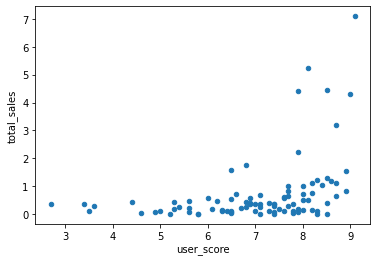

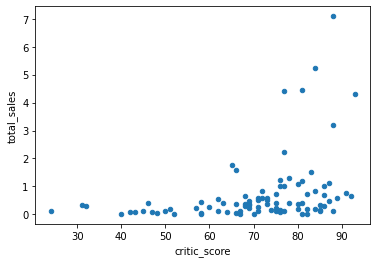

In [31]:
wiiu = df_actual.query('platform == "WiiU" and user_score>0 and critic_score>0')
wiiu.plot(x='user_score', y='total_sales', kind='scatter')
wiiu.plot(x='critic_score', y='total_sales', kind='scatter')
display(wiiu['user_score'].corr(wiiu['total_sales']))
wiiu['critic_score'].corr(wiiu['total_sales'])

0.022846157392019666

0.3893352638493179

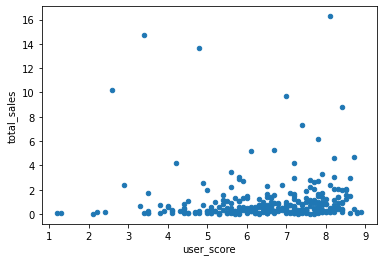

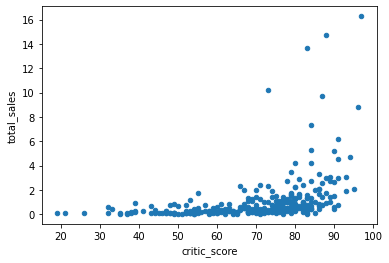

In [32]:
x360 = df_actual.query('platform == "X360" and user_score>0 and critic_score>0')
x360.plot(x='user_score', y='total_sales', kind='scatter')
x360.plot(x='critic_score', y='total_sales', kind='scatter')
display(x360['user_score'].corr(x360['total_sales']))
x360['critic_score'].corr(x360['total_sales'])

Похожие данные показывает диаграмма и корреляция по х360 (0.04 с отзывами пользователей и 0.3 с отзывами экспертов). А вот у платформы WiiU почти одинаковая корреляция с отзывами пользователей и экспертов - 0.3. Тем не менее это слабая взаимосвязь. Однако на графике можно заметить, что высокие продажи у платформы WiiU случаются при рейтинге пользователей больше 8 и экспертном рейтинге больше 70

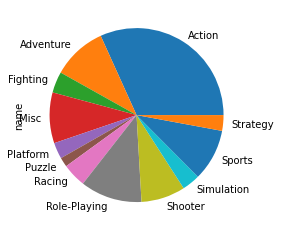

In [33]:
df_actual.groupby('genre')['name'].count().plot(kind='pie')
plt.show()


По количеству игр лидирует action, меньшие доли у приключений, спортивных и ролевых игр, самая малая доля у головоломок.

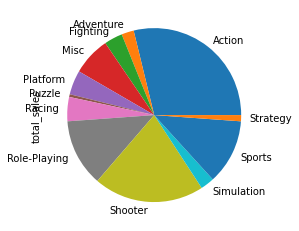

In [34]:
df_actual.groupby('genre')['total_sales'].sum().plot(kind='pie')
plt.show()

По продажам немного другая картина, хотя лидер тот же - это action. Большая доля продаж в жанре шутеры, ролевые и спортивные игры. Самые низкие продажи у головоломок.

Рассматрим подробнее средние и медианные значения в продажах по жанрам

In [35]:
genre_sales = df_actual.pivot_table(index='genre', values='total_sales', aggfunc=['mean','median'])
genre_sales

,mean,median
,total_sales,total_sales
genre,,
Action,0.439176,0.130
Adventure,0.109854,0.030
Fighting,0.420755,0.180
Misc,0.366257,0.120
Platform,0.726885,0.185
Puzzle,0.138732,0.050
Racing,0.490611,0.160
Role-Playing,0.528237,0.150


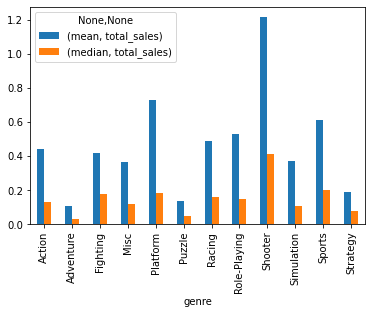

In [36]:
genre_sales.plot(kind='bar')
plt.show()

Сводная таблица показывает, что наиболее высокие средние продажи у шутеров, почти в два раза первышают следующие за ней по продажам платформенные и спортивные

*Вывод по шагу Исследовательский анализ*

1) В исследовательском анализе был рассчитан актуальный период для исследования, исходя из данных о количестве игр, выпускавшихся в разные годы на разных платформах. 

2) Были определены потенциальные прибыльные платформы на основе актуального периода.

3) Проанализированы связи между продажами и пользовательскими и экспертными рейтингами.

Сфера игр быстро меняется. Это показали графики, на смену одним платформам приходят другие, поэтому следует учитывать более короткие временные отрезки, так как сфера быстрообновляющаяся, а для построения прогнозов, вероятно, стоит брать отрезок 1-2 года. Исследование показало, что можно считать "набирающими обороты"/растущими в продажах, а следовательно потенциально прибыльными XOne, WiiU, а также PC. Ислледования взаимосвязи по двум факторам не показали в корреляции сильного значения, однако на графиках можно увидеть связи между высокими продажами и экспертными и пользовательскими рейтингами

**Шаг 4. Портрет пользователя**

In [37]:
na = df_actual.groupby('platform')['na_sales'].sum().sort_values(ascending=False).to_frame().head(5)
eu = df_actual.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).to_frame().head(5)
jp = df_actual.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).to_frame().head(5)
display(na,eu,jp)


,na_sales
platform,
X360,228.18
PS3,168.96
PS4,108.74
XOne,93.12
3DS,82.83


,eu_sales
platform,
PS3,164.15
PS4,141.09
X360,117.87
3DS,61.46
PC,57.38


,jp_sales
platform,
3DS,100.62
PS3,49.40
PSP,24.28
PSV,21.84
PS4,15.96


Платформы PS3 и PS4 есть во всех трех страновых группах, в Европе они занимают первые места по продажам, в Америке - 2е и 3е, в Японии - 2-е и 5-е. В Америке уверенно лидирет х360, а в Японии так же уверенно - 3DS.

In [38]:
na = df_actual.groupby('genre')['na_sales'].sum().sort_values(ascending=False).to_frame().head(5)
eu = df_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).to_frame().head(5)
jp = df_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).to_frame().head(5)
display(na,eu,jp)

,na_sales
genre,
Action,234.41
Shooter,194.45
Sports,108.70
Role-Playing,83.78
Misc,69.81


,eu_sales
genre,
Action,202.17
Shooter,148.05
Sports,88.67
Role-Playing,62.30
Racing,40.58


,jp_sales
genre,
Role-Playing,79.87
Action,63.63
Misc,17.85
Fighting,12.38
Platform,12.13


По жанрам на первом месте в Европе и Америке action. Отрыв от второго места около 20%. А вот в Японии action только на втором месте, там лидируют ролевые игры, также примерно с 20%-м отрывом. Картина по Европе и Америке во многом похожа: первые 4 места там распределились одинаково - 1)экшн 2) шутеры 3) спортивные 4) ролевые. И лишь на пятом месте разные: в Европе - гонки, в Америке - "разное". Япония имеет совпадение с западом лишь в двух случаях - ролевые и экшн, как и в Америке здесь любят игры из категории "разное", а также борьба и платформенные, но на их долю приходится значительно меньше продаж.

In [39]:
na = df_actual.groupby('rating')['na_sales'].sum().sort_values(ascending=False).to_frame().head(5)
eu = df_actual.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).to_frame().head(5)
jp = df_actual.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).to_frame().head(5)
display(na,eu,jp)

,na_sales
rating,
M,309.32
E,170.25
no rating,124.03
E10+,119.95
T,109.62


,eu_sales
rating,
M,251.40
E,141.93
no rating,116.67
T,83.37
E10+,79.88


,jp_sales
rating,
no rating,138.46
E,36.68
T,33.39
M,26.15
E10+,11.23


Здесь также можно заметить отличие результатов по Японии от Европы и Америки. В Европе и Америке на 1м и 2м месте соответственно M(mature) для взрослых и E(everyone) для всех. У Японии на первом месте игры, где возрастной рейтинг не определен, на втором E(everyone) для всех. Также доли продаж по рейтингам У Японии меньше, чем у Америки и Европы.

**Шаг 5. Проверка гипотез**

Нужно проверить две гипотезы:
- средние пользовательские рейтинги Xbox One и PC одинаковые
- средние пользовательские рейтинги жанров Action и Sports разные

*Формулирование гипотез*

1) - Нулевая гипотеза (Н0) - средние пользовательские рейтинги Xbox one и PC равны

Альтернативная гипотеза (Н1) = средние пользовательские рейтинги Xbox one и PC  не равны

2) - Нулевая гипотеза (Н0) - средние пользовательские рейтинги Action и Sports равны

Альтернативная гипотеза (Н1) - средние пользовательские рейтинги Action и Sports не равны

In [40]:
df_actual['platform'].value_counts()
xbox = df_actual.query('platform == "XOne" and user_score>0')
pc = df_actual.query('platform == "PC" and user_score>0')   
sample_xbox = xbox['user_score']
sample_pc = pc['user_score']

Делаю срезы с двумя выборками. Данные для теста сохраняю в переменных sample. Так как надо сравнить две средние совокупности, взятые по выборкам, я буду использовать тест ttest_ind

In [41]:
alpha = .05
results = st.ttest_ind(sample_xbox,sample_pc)
results.pvalue

display('p-значение:',results.pvalue)

if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не отвергаем нулевую гипотезу')

display ('Xbox рейтинг Среднее', sample_xbox.mean())
display ('PC рейтинг Среднее', sample_pc.mean())

'p-значение:'

0.6981816747159801

'Не отвергаем нулевую гипотезу'

'Xbox рейтинг Среднее'

6.52142857142857

'PC рейтинг Среднее'

6.466242038216563

In [42]:
action = df_actual.query('genre == "Action" and user_score>0')
sports = df_actual.query('genre == "Sports" and user_score>0')   
sample_action = action['user_score']
sample_sports = sports['user_score']

In [43]:
alpha = .05
results = st.ttest_ind(sample_action,sample_sports)
results.pvalue

display('p-значение:',results.pvalue)

if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не отвергаем нулевую гипотезу')

display ('Action рейтинг Среднее', sample_action.mean())
display ('Sports рейтинг Среднее', sample_sports.mean())

'p-значение:'

1.551415375928656e-24

'Отвергаем нулевую гипотезу'

'Action рейтинг Среднее'

6.783851851851868

'Sports рейтинг Среднее'

5.650813008130081

Для первого теста осталась в силе нулевая гипотеза: средние пользовательские рейтинги Xbox One и PC равны. Для второго теста - альтернативная гипотеза: пользвотельские средние рейтинги в жанрах action и sports не равны

**Шаг 6. Общий вывод**

В исследовании была проведена:
- подготовка данных
- исследовательский анализ
- составлен портрет пользователя по регионам
- проверены две гипотезы

а)Исследовательский анализ показал, что в данном случае смотреть на данные за все периоды не является целесообразным, так как в игровой индустрии изменения происходят постоянно - обновляются платформы, появляются новые игры. Графики показали, что характерный срок, за который появляются новые и исчезают старые платформы - 8-10 лет. В лидерах платформы Xbox, PS, PC, Wii, а на актуальный период ожидается рост Xbox One и WiiU. 

b)Что касается потрета пользователя, то заметны отличия аудитории из Японии по сравнению с Америкой и Европой. Там в лидерах разные платформы и разные жанры, к примеру, в Европе и Америке на первом месте Action, тогда как в Японии ролевые игры.

c)Тесты на равенство средних рейтингов по платформам Xbox One и PC и по жанрам action и sports показали, что средние по платформам равны, а по жанрам - нет.